<a href="https://colab.research.google.com/github/surajsrivathsa/image_registration/blob/main/SCG_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install voxelmorph 

     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 92kB 10.1MB/s 


In [4]:
import numpy as np
from matplotlib import pyplot as plt
import neurite as ne
import nibabel as nb
import os, sys, glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import gc
import skimage.transform as skt

In [5]:
print("nibabel version: {}".format(nb.__version__))
print("pytorch version: {}".format(torch.__version__))
print("numpy version: {}".format(np.__version__))

nibabel version: 3.0.2
pytorch version: 1.8.0+cu101
numpy version: 1.19.5


In [6]:
data_path_t1 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Voxelmorph_dataset_downsampled/"
data_path_t2 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/Voxelmorph_dataset_downsampled/"
file_names_t1 = sorted(glob.glob(os.path.join(data_path_t1, "*.nii.gz")))
file_names_t2 = sorted(glob.glob(os.path.join(data_path_t2, "*.nii.gz")))

In [111]:
from random import randint, seed
seed(1)

# Dataset Creation

In [7]:
def load_4D(name):
    model_np = np.zeros(shape=(128, 128, 128))
    X_nb = nb.load(name)
    X_np = X_nb.dataobj
    #print("Oreintation: {}".format(nb.aff2axcodes(X_nb.affine)))
    #model_np[:, :, 0:X_np.shape[2]] = X_np[0:128, 0:128, :]
    #model_np = np.reshape(model_np, (1,)+ model_np.shape)
    model_np = np.reshape(X_np, (1,)+ X_np.shape)
    return model_np

def imgnorm(N_I,index1=0.0001,index2=0.0001):
    I_sort = np.sort(N_I.flatten())
    I_min = I_sort[int(index1*len(I_sort))]
    I_max = I_sort[-int(index2*len(I_sort))]
    N_I =1.0*(N_I-I_min)/(I_max-I_min)
    N_I[N_I>1.0]=1.0
    N_I[N_I<0.0]=0.0
    N_I2 = N_I.astype(np.float32)
    return N_I2

def Norm_Zscore(img):
    img= (img-np.mean(img))/np.std(img) 
    return img

def downsample(img):
    dimg = skt.resize(img, (1, 64, 64, 64), 3)
    return dimg

In [116]:
class Dataset(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, t1_filenames, t2_filenames, iterations=1,norm=True):
        'Initialization'
        self.t1_filenames = t1_filenames
        self.t2_filenames = t2_filenames
        self.norm = norm
        self.iterations = iterations
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.t1_filenames) * self.iterations

  def __getitem__(self, idx):
        'Generates one sample of data'
        A_idx = randint(0, len(self.t1_filenames)-1)
        B_idx = randint(0, len(self.t1_filenames)-1)
        if (A_idx == B_idx):
          B_idx = (B_idx + 1) % (len(self.t1_filenames)-1)

        #img_A = load_4D(self.t1_filenames[idx])
        #img_B = load_4D(self.t1_filenames[(idx + 4) % len(self.t1_filenames)])

        img_A = load_4D(self.t1_filenames[A_idx])
        img_B = load_4D(self.t1_filenames[B_idx])

        #print(A_idx, B_idx)
                       
        if self.norm:
            #return  Norm_Zscore(imgnorm(img_A)) , Norm_Zscore(imgnorm(img_B))
            full_img_A = imgnorm(img_A) 
            full_img_B = imgnorm(img_B)
            return  full_img_A , full_img_B
        else:
            return img_A, img_B

In [140]:
class ValidationDataset(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, t1_filenames, t2_filenames, iterations=1,norm=True):
        'Initialization'
        self.t1_filenames = t1_filenames
        self.t2_filenames = t2_filenames
        self.norm = norm
        self.iterations = iterations
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.t1_filenames) * self.iterations

  def __getitem__(self, idx):
        """
        A_idx = randint(0, len(self.t1_filenames)-1)
        B_idx = randint(0, len(self.t1_filenames)-1)
        if (A_idx == B_idx):
          B_idx = (B_idx + 1) % (len(self.t1_filenames)-1)
        
        """

        img_A = load_4D(self.t1_filenames[idx])
        img_B = load_4D(self.t1_filenames[(idx + 4) % len(self.t1_filenames)])

        #img_A = load_4D(self.t1_filenames[A_idx])
        #img_B = load_4D(self.t1_filenames[B_idx])

        #print(A_idx, B_idx)
                       
        if self.norm:
            #return  Norm_Zscore(imgnorm(img_A)) , Norm_Zscore(imgnorm(img_B))
            full_img_A = imgnorm(img_A) 
            full_img_B = imgnorm(img_B)
            return  full_img_A , full_img_B
        else:
            return img_A, img_B

In [117]:
training_generator = Data.DataLoader(Dataset(file_names_t1, file_names_t2,norm=True), batch_size=5, shuffle=False)

In [141]:
validation_generator = Data.DataLoader(ValidationDataset(file_names_t1, file_names_t2,norm=True), batch_size=1, shuffle=False)

In [121]:
for X,Y in training_generator:
  print(X.shape)
  print(Y.shape)
  del X, Y
  break

torch.Size([5, 1, 128, 128, 128])
torch.Size([5, 1, 128, 128, 128])


# Feature Extractor Model Creation

In [52]:
class Feature_Extractor(nn.Module):
  def __init__(self,in_channel, n_classes, start_channel):
        self.in_channel = in_channel
        self.n_classes = n_classes
        self.start_channel = start_channel
        super(Feature_Extractor, self).__init__()
        self.en0 = self.encoder(self.in_channel, self.start_channel, bias=False)

        self.en1 = self.encoder(self.start_channel * 1, self.start_channel * 2, stride=2, bias=True)
        self.en2 = self.encoder(self.start_channel * 2, self.start_channel * 3, stride=2, bias=True)
        self.en3 = self.encoder(self.start_channel * 3, self.start_channel * 4, stride=2, bias=True)
        self.en4 = self.encoder(self.start_channel * 4, self.start_channel * 5, stride=2, bias=True)
        self.en5 = self.encoder(self.start_channel * 5, self.start_channel * 6, stride=2, bias=True)

  def encoder(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
    layer = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.BatchNorm3d(out_channels),
                nn.ReLU())
    return layer

  def forward(self, x,y):
        # print("x,y", x.shape, "  ", y.shape)
        x_in=torch.cat((x, y), 1)  
        enc_op = self.en0(x_in)
        enc_op = self.en1(enc_op)
        enc_op_p = self.en2(enc_op)
        enc_op = self.en3(enc_op_p) # 16
        #enc_op = self.en4(enc_op) # 8

        # Last encoders latent space 1/32 times original dim , 4
        #enc_op = self.en5(enc_op)

        return enc_op, enc_op_p

In [13]:
model = Feature_Extractor(2,3,8)

In [ ]:
count = 0
for X, Y in training_generator:
  feature_extractor_op = model(X, Y)
  print(feature_extractor_op.shape)
  del feature_extractor_op
  if (count > 2):
    break
  
  count = count+ 1
  

torch.Size([4, 40, 8, 8, 8])
torch.Size([4, 40, 8, 8, 8])
torch.Size([4, 40, 8, 8, 8])
torch.Size([4, 40, 8, 8, 8])


# Upsampler Model creation

In [71]:
class Upsampler_net(nn.Module):
  def __init__(self, in_channel ):
        
        self.in_channel = in_channel
        super(Upsampler_net, self).__init__()
        
        self.up0 = self.decoder(self.in_channel*4, self.in_channel*3)
        self.up1 = self.decoder(3, 3)
        self.up2 = self.decoder(self.in_channel*2, self.in_channel*1)

        self.conv1X1_1 = self.conv1X1(24, 3)


        #self.dc4 = self.output(self.start_channel, self.n_classes,kernel_size=1,bias=False)

  def decoder(self, in_channels, out_channels, kernel_size=2, stride=2, padding=0,
                output_padding=0, bias=True):
    layer = nn.Sequential(
                nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride=stride,
                               padding=padding, output_padding=output_padding, bias=bias),
                                nn.LeakyReLU())
    return layer
       
  def output(self, in_channels, out_channels, kernel_size=3, padding=1, bias=False, batchnorm=False):
    layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, bias=bias, padding=padding),)
    return layer

  def conv1X1(self, in_channels, out_channels, kernel_size=1, padding=0, bias=False, batchnorm=False):
    layer = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size, bias=bias, padding=padding),)
    return layer

  def forward(self, latent_space_feats, additional_encoder_feats1 ):

        d0 = torch.add(self.up1(latent_space_feats), self.conv1X1_1(additional_encoder_feats1))
        
        return d0

In [72]:
upsampler_model = Upsampler_net(8)
latent_feats_tnsr = torch.randn(size=(5, 3, 16, 16, 16))
encoder_feats_tnsr = torch.randn(size=(5, 24, 32, 32, 32))

In [73]:
umo = upsampler_model(latent_feats_tnsr, encoder_feats_tnsr)

In [62]:
del encoder_feats_tnsr, latent_feats_tnsr

# SCG Model Creation

In [23]:
class SCG_block(nn.Module):
    def __init__(self, in_ch, hidden_ch=3, node_size=(8, 8, 8), add_diag=True, dropout=0.2):
        super(SCG_block, self).__init__()
        self.node_size = node_size
        self.hidden = hidden_ch
        self.nodes = node_size[0]*node_size[1]*node_size[2]
        self.add_diag = add_diag
        self.pool = nn.AdaptiveAvgPool3d(node_size)

        self.mu = nn.Sequential(
            nn.Conv3d(in_ch, hidden_ch, 3, padding=1, bias=True),
            nn.Dropout(dropout),
        )

        self.logvar = nn.Sequential(
            nn.Conv3d(in_ch, hidden_ch, 1, 1, bias=True),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        B, C, H, W, D = x.size()
        gx = self.pool(x)

        mu, log_var = self.mu(gx), self.logvar(gx)

        if self.training:
            std = torch.exp(log_var.reshape(B, self.nodes, self.hidden))
            eps = torch.randn_like(std)
            z = mu.reshape(B, self.nodes, self.hidden) + std*eps
        else:
            z = mu.reshape(B, self.nodes, self.hidden)

        A = torch.matmul(z, z.permute(0, 2, 1))
        A = torch.relu(A)

        Ad = torch.diagonal(A, dim1=1, dim2=2)
        mean = torch.mean(Ad, dim=1)
        gama = torch.sqrt(1 + 1.0 / mean).unsqueeze(-1).unsqueeze(-1)

        dl_loss = gama.mean() * torch.log(Ad[Ad<1]+ 1.e-7).sum() / (A.size(0) * A.size(1) * A.size(2))

        kl_loss = -0.5 / self.nodes * torch.mean(
            torch.sum(1 + 2 * log_var - mu.pow(2) - log_var.exp().pow(2), 1)
        )

        loss = kl_loss - dl_loss

        if self.add_diag:
            diag = []
            for i in range(Ad.shape[0]):
                diag.append(torch.diag(Ad[i, :]).unsqueeze(0))

            A = A + gama * torch.cat(diag, 0)
            # A = A + A * (gama * torch.eye(A.size(-1), device=A.device).unsqueeze(0))

        # A = laplacian_matrix(A, self_loop=True)
        A = self.laplacian_matrix(A, self_loop=True)
        # A = laplacian_batch(A.unsqueeze(3), True).squeeze()

        z_hat = gama.mean() * \
                mu.reshape(B, self.nodes, self.hidden) * \
                (1. - log_var.reshape(B, self.nodes, self.hidden))

        return A, gx, loss, z_hat

    @classmethod
    def laplacian_matrix(cls, A, self_loop=False):
        '''
        Computes normalized Laplacian matrix: A (B, N, N)
        '''
        if self_loop:
            A = A + torch.eye(A.size(1), device=A.device).unsqueeze(0)
        # deg_inv_sqrt = (A + 1e-5).sum(dim=1).clamp(min=0.001).pow(-0.5)
        deg_inv_sqrt = (torch.sum(A, 1) + 1e-5).pow(-0.5)

        LA = deg_inv_sqrt.unsqueeze(-1) * A * deg_inv_sqrt.unsqueeze(-2)

        return LA



In [30]:
sb = SCG_block(in_ch=40, hidden_ch=3, node_size=(8, 8, 8))

In [24]:
count = 0
for X, Y in training_generator:

  feature_extractor_op = model(X, Y)
  print(feature_extractor_op.shape)
  print()

  B, C = feature_extractor_op.shape[0], feature_extractor_op.shape[1] 
  A, gx, loss, z_hat = sb(feature_extractor_op)
  print(A.shape, gx.shape, loss.shape, z_hat.shape)
  print(loss)
  torch.bmm(A, (gx.reshape(B, -1, C)))
  print("============= =============== ===========")

  del feature_extractor_op, A, gx, loss, z_hat
  if (count > 1):
    break
  
  count = count+ 1

torch.Size([5, 32, 16, 16, 16])



NameError: ignored

In [25]:
class GCN_Layer(nn.Module):
    def __init__(self, in_features, out_features, bnorm=True, activation=nn.ReLU(), dropout=None):
        super(GCN_Layer, self).__init__()
        self.bnorm = bnorm
        fc = [nn.Linear(in_features, out_features)]
        if bnorm:
            fc.append(BatchNorm_GCN(out_features))
        if activation is not None:
            fc.append(activation)
        if dropout is not None:
            fc.append(nn.Dropout(dropout))
        self.fc = nn.Sequential(*fc)

    def forward(self, data):
        x, A = data
        tbmm = torch.bmm(A, x)
        
        y = self.fc(tbmm)

        return [y, A]


In [26]:
def weight_xavier_init(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                # nn.init.xavier_normal_(module.weight)
                nn.init.orthogonal_(module.weight)
                # nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()


In [29]:
class BatchNorm_GCN(nn.BatchNorm1d):
    '''Batch normalization over GCN features'''

    def __init__(self, num_features):
        super(BatchNorm_GCN, self).__init__(num_features)

    def forward(self, x):
        return super(BatchNorm_GCN, self).forward(x.permute(0, 2, 1)).permute(0, 2, 1)


In [31]:
graph_layers1 = GCN_Layer(40, 16, bnorm=True, activation=nn.ReLU(True), dropout=0.1)

graph_layers2 = GCN_Layer(16, 3, bnorm=False, activation=None)

In [32]:
weight_xavier_init(graph_layers1, graph_layers2, sb)

In [ ]:
count = 0
for X, Y in training_generator:
  x_size = X.size()

  feature_extractor_op = model(X, Y)
  print(feature_extractor_op.shape)
  print()

  A, gx, loss, z_hat = sb(feature_extractor_op)
  
  B, C, H, W, D = feature_extractor_op.size()
  print(A.shape, gx.shape, loss.shape, z_hat.shape, gx.reshape(B, -1, C).shape)
  print(loss)
  print()

  gop_layers1, A_layers1 = graph_layers1((gx.reshape(B, -1, C), A))
  print(gop_layers1.shape, A_layers1.shape)
  print()
  
  gop_layers2, A_layers2 = graph_layers2((gop_layers1, A_layers1))
  print(gop_layers2.shape, A_layers2.shape)

  gop_layers2 = gop_layers2 + z_hat

  gx = gop_layers2.reshape(B, 3, 8, 8, 8)

  

  gx = F.interpolate(gx, (H, W, D), mode='trilinear', align_corners=False)
  print(gx.shape)

  gx = F.interpolate(gx, x_size[2:], mode='trilinear', align_corners=False)
  print(gx.shape)


  print("============= =============== ===========")

  del feature_extractor_op, A, gx, loss, z_hat, gop_layers1, A_layers1, gop_layers2, A_layers2


  if (count > 1):
    break
  
  count = count+ 1

torch.Size([4, 40, 8, 8, 8])

torch.Size([4, 512, 512]) torch.Size([4, 40, 8, 8, 8]) torch.Size([]) torch.Size([4, 512, 3]) torch.Size([4, 512, 40])
tensor(0.0042, grad_fn=<SubBackward0>)

torch.Size([4, 512, 16]) torch.Size([4, 512, 512])

torch.Size([4, 512, 3]) torch.Size([4, 512, 512])
torch.Size([4, 3, 8, 8, 8])
torch.Size([4, 3, 128, 128, 128])
============= =============== ===========
torch.Size([4, 40, 8, 8, 8])

torch.Size([4, 512, 512]) torch.Size([4, 40, 8, 8, 8]) torch.Size([]) torch.Size([4, 512, 3]) torch.Size([4, 512, 40])
tensor(0.0048, grad_fn=<SubBackward0>)

torch.Size([4, 512, 16]) torch.Size([4, 512, 512])

torch.Size([4, 512, 3]) torch.Size([4, 512, 512])
torch.Size([4, 3, 8, 8, 8])
torch.Size([4, 3, 128, 128, 128])
============= =============== ===========
torch.Size([4, 40, 8, 8, 8])

torch.Size([4, 512, 512]) torch.Size([4, 40, 8, 8, 8]) torch.Size([]) torch.Size([4, 512, 3]) torch.Size([4, 512, 40])
tensor(0.0064, grad_fn=<SubBackward0>)

torch.Size([4, 512, 1

# Spatial Transformer

In [40]:
class SpatialTransformer(nn.Module):
    """
    N-D Spatial Transformer
    """

    def __init__(self, size, is_affine=False, theta = None, mode='bilinear', affine_image_size =  (2, 1, 128, 128, 128)):
        super().__init__()

        self.mode = mode
        self.isaffine = is_affine
        self.theta = theta
        self.affine_image_size =  affine_image_size
        # create sampling grid
        # registering the grid as a buffer cleanly moves it to the GPU, but it also
        # adds it to the state dict. this is annoying since everything in the state dict
        # is included when saving weights to disk, so the model files are way bigger
        # than they need to be. so far, there does not appear to be an elegant solution.
        # see: https://discuss.pytorch.org/t/how-to-register-buffer-without-polluting-state-dict

        if (self.isaffine):
          grid = F.affine_grid(self.theta, self.affine_image_size, align_corners=False)
          #grid = grid.permute(0, 4, 1, 2, 3)
          self.register_buffer('grid', grid)
        else:
          vectors = [torch.arange(0, s) for s in size]
          grids = torch.meshgrid(vectors)
          grid = torch.stack(grids)
          grid = torch.unsqueeze(grid, 0)
          grid = grid.type(torch.FloatTensor)
          self.register_buffer('grid', grid)

    def forward(self, src, flow=None):      
      if (self.isaffine):
        grid = F.affine_grid(self.theta, self.affine_image_size)        
        warped_image = F.grid_sample(src, grid)
        #warped_image = warped_image.permute(0, 4, 1, 2, 3)
        return warped_image
      else:
        # new locations
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        # move channels dim to last position
        # also not sure why, but the channels need to be reversed
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]

        return F.grid_sample(src, new_locs, align_corners=True, mode=self.mode)

# Losses

In [33]:
def normalized_cross_correlation(x, y, return_map, reduction='mean', eps=1e-8):
    """ N-dimensional normalized cross correlation (NCC)
    Args:
        x (~torch.Tensor): Input tensor.
        y (~torch.Tensor): Input tensor.
        return_map (bool): If True, also return the correlation map.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``'mean'`` | ``'sum'``. Defaults to ``'sum'``.
        eps (float, optional): Epsilon value for numerical stability. Defaults to 1e-8.
    Returns:
        ~torch.Tensor: Output scalar
        ~torch.Tensor: Output tensor
    """

    shape = x.shape
    b = shape[0]

    # reshape
    x = x.view(b, -1)
    y = y.view(b, -1)

    # mean
    x_mean = torch.mean(x, dim=1, keepdim=True)
    y_mean = torch.mean(y, dim=1, keepdim=True)

    # deviation
    x = x - x_mean
    y = y - y_mean

    dev_xy = torch.mul(x,y)
    dev_xx = torch.mul(x,x)
    dev_yy = torch.mul(y,y)

    dev_xx_sum = torch.sum(dev_xx, dim=1, keepdim=True)
    dev_yy_sum = torch.sum(dev_yy, dim=1, keepdim=True)

    ncc = torch.div(dev_xy + eps / dev_xy.shape[1],
                    torch.sqrt( torch.mul(dev_xx_sum, dev_yy_sum)) + eps)
    ncc_map = ncc.view(b, *shape[1:])

    # reduce
    if reduction == 'mean':
        ncc = torch.mean(torch.sum(ncc, dim=1))
    elif reduction == 'sum':
        ncc = torch.sum(ncc)
    else:
        raise KeyError('unsupported reduction type: %s' % reduction)

    if not return_map:
        return ncc
    
    if (torch.isclose(torch.tensor([-1.0]).to("cuda"), ncc).any()):
      ncc = ncc + torch.tensor([0.01]).to("cuda")

    elif (torch.isclose(torch.tensor([1.0]).to("cuda"), ncc).any()):
      ncc = ncc - torch.tensor([0.01]).to("cuda")

    return ncc, ncc_map


In [34]:
class NormalizedCrossCorrelation(nn.Module):
    """ N-dimensional normalized cross correlation (NCC)
    Args:
        eps (float, optional): Epsilon value for numerical stability. Defaults to 1e-8.
        return_map (bool, optional): If True, also return the correlation map. Defaults to False.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``'mean'`` | ``'sum'``. Defaults to ``'mean'``.
    """
    def __init__(self,
                 eps=1e-8,
                 return_map=False,
                 reduction='mean'):

        super(NormalizedCrossCorrelation, self).__init__()

        self._eps = eps
        self._return_map = return_map
        self._reduction = reduction

    def forward(self, x, y):

        return normalized_cross_correlation(x, y,self._return_map, self._reduction, self._eps)

# Regularizer

In [35]:
def smoothness_regularizer( input_tensor=None):
  if(input_tensor == None):
    dvf_tensor = torch.randn(size=(4, 3, 128, 128, 128)).cuda()
  else:
    dvf_tensor = input_tensor
  
  dvf_x = dvf_tensor[:, 0:1, ...]
  dvf_y = dvf_tensor[:, 1:2, ...]
  dvf_z = dvf_tensor[:, 2:3, ...]

  sobel_z = torch.FloatTensor( [ [ [ [ [1,2,1], [2,4,2], [1,2,1] ], [ [0,0,0], [0,0,0], [0,0,0] ], [ [-1,-2,-1], [-2,-4,-2], [-1,-2,-1] ] ] ] ] ).cuda()
  sobel_y = torch.FloatTensor( [ [ [ [ [1,2,1], [0,0,0], [-1,-2,-1] ], [ [2,4,2], [0,0,0], [-2,-4,-2] ], [ [1,2,1], [0,0,0], [-1,-2,-1] ] ] ] ] ).cuda()
  sobel_x = torch.FloatTensor( [ [ [ [ [1,0,-1], [2,0,-2], [1,0,-1] ], [ [2,0,-2], [4,0,-4], [2,0,-2] ], [ [1,0,-1], [2,0,-2], [1,0,-1] ] ] ] ] ).cuda()

  edges_x = F.conv3d(input=dvf_x, weight=sobel_x , stride=1, padding=1)
  edges_y = F.conv3d(input=dvf_y, weight=sobel_y , stride=1, padding=1)
  edges_z = F.conv3d(input=dvf_z, weight=sobel_z , stride=1, padding=1)

  magnitude_of_edges_along_x = torch.norm(edges_x)
  magnitude_of_edges_along_y = torch.norm(edges_y)
  magnitude_of_edges_along_z = torch.norm(edges_z)
  #print("Magnitudes of gradients along x, y and z are {}, {} and {}".format(magnitude_of_edges_along_x, magnitude_of_edges_along_y, magnitude_of_edges_along_z))

  return magnitude_of_edges_along_x + magnitude_of_edges_along_y + magnitude_of_edges_along_z

In [36]:
class Smoothnessloss(nn.Module):
    def __init__(self):

        super(Smoothnessloss, self).__init__()
        
    def forward(self, x):
        smth_loss = smoothness_regularizer( x)
        return torch.sqrt(smth_loss)

# Training

In [74]:
!nvidia-smi

Tue Mar 30 10:29:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    28W /  70W |  11134MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [122]:
del feature_extractor_training, scg_training, upsampler_training, graph_layers1_training, graph_layers2_training, stn_deformable
torch.cuda.empty_cache()

In [123]:
feature_extractor_training = Feature_Extractor(2,3,8).to("cuda")

scg_training = SCG_block(in_ch=32, hidden_ch=3, node_size=(16, 16, 16)).to("cuda")

upsampler_training = Upsampler_net(8).to("cuda")

graph_layers1_training = GCN_Layer(32, 16, bnorm=True, activation=nn.ReLU(True), dropout=0.1).to("cuda")

graph_layers2_training = GCN_Layer(16, 3, bnorm=False, activation=None).to("cuda")

stn_deformable = SpatialTransformer(size=(128, 128, 128), is_affine=False).to("cuda")

weight_xavier_init(graph_layers1_training, graph_layers2_training, scg_training)

for param in stn_deformable.parameters():
  param.requires_grad = False
  param.volatile=True


In [127]:
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/scgnet/scgnet_withupsample_16_30.pth')

feature_extractor_training.load_state_dict(checkpoint['feature_extractor_training'])
scg_training.load_state_dict(checkpoint['scg_training'])
upsampler_training.load_state_dict(checkpoint['upsampler_training'])
graph_layers1_training.load_state_dict(checkpoint['graph_layers1_training'])
graph_layers2_training.load_state_dict(checkpoint['graph_layers2_training'])

<All keys matched successfully>

In [128]:
similarity_loss = NormalizedCrossCorrelation().to("cuda")
smoothness_loss = Smoothnessloss().to("cuda")
lr=1e-4

In [129]:
optimizer = torch.optim.Adam( list( feature_extractor_training.parameters()) + list( scg_training.parameters() ) + 
                             list(upsampler_training.parameters()) +
                             list( graph_layers1_training.parameters()) + list(graph_layers2_training.parameters() ), lr=lr ) 
model_dir = '/content/drive/My Drive/Image_Registration_Project/scgnet'

if not os.path.isdir(model_dir):
  os.mkdir(model_dir)


In [132]:
# X --> fixed and Y --> moving
def fullmodel_one_epoch_run(epoch=1):
  example_number = 0
  for X,Y in training_generator:

    X = X.float().to("cuda")
    Y = Y.float().to("cuda")

    x_size = X.size()

    feature_extractor_op, feature_extractor_op_p = feature_extractor_training(X, Y)
    #print(feature_extractor_op.shape)
    #print()

    A, gx, scg_loss, z_hat = scg_training(feature_extractor_op)
    
    B, C, H, W, D = feature_extractor_op.size()
    #print(A.shape, gx.shape, loss.shape, z_hat.shape, gx.reshape(B, -1, C).shape)
    #print(loss)
    #print()

    gop_layers1, A_layers1 = graph_layers1_training((gx.reshape(B, -1, C), A))
    #print(gop_layers1.shape, A_layers1.shape)
    #print()
    
    gop_layers2, A_layers2 = graph_layers2_training((gop_layers1, A_layers1))
    #print(gop_layers2.shape, A_layers2.shape)

    gop_layers2 = gop_layers2 + z_hat

    gx = gop_layers2.reshape(B, 3, 16, 16, 16)

    gx = F.interpolate(gx, (H, W, D), mode='trilinear', align_corners=False)
    #print(gx.shape)

    # Adding information from feature extractor directly to latent space info, this could provide a path for gradients to move faster
    gx = upsampler_training(gx, feature_extractor_op_p)

    dvf = F.interpolate(gx, x_size[2:], mode='trilinear', align_corners=False)
    #print(gx.shape)

    fully_warped_image =  stn_deformable(Y, dvf)

    cc_loss = similarity_loss(X, fully_warped_image)
    sm_loss = smoothness_loss(dvf)

    total_loss = -10.0 * cc_loss + 10.0 * scg_loss + 0.005 * sm_loss

    optimizer.zero_grad()          
    total_loss.backward() 
    optimizer.step()


    #print("============= =============== ===========")

    np.save(os.path.join(model_dir, "scgnet_withupsample_16_plot_loss_2.npy"), np.array( [scg_loss.detach().to("cpu").numpy(), cc_loss.detach().to("cpu").numpy(), total_loss.detach().to("cpu").numpy(), 
                                                                 sm_loss.detach().to("cpu").numpy(), epoch, example_number] ))

    del X, Y, feature_extractor_op, feature_extractor_op_p, A, gx, z_hat, gop_layers1, A_layers1, gop_layers2, A_layers2, dvf, fully_warped_image
    torch.cuda.empty_cache() 
   
    example_number = example_number + 1
    


  if (epoch%2 == 0):
    modelname = model_dir + '/' + "scgnet_withupsample_16_" + str(epoch + 0) + '.pth'
    torch.save({"feature_extractor_training": feature_extractor_training.state_dict(), "scg_training": scg_training.state_dict(), "upsampler_training": upsampler_training.state_dict(),
                "graph_layers1_training": graph_layers1_training.state_dict(), "graph_layers2_training": graph_layers2_training.state_dict()}, modelname)
    print("epoch: {}".format(epoch))
    print("Losses: {}, {} {} and {}".format(cc_loss * -10.0, scg_loss * 10.0, 0.001 * sm_loss, total_loss))
    print("Saving model checkpoints")
    print("======= =============== ===========")
    print()

In [133]:
epochs = 51
for e in range(epochs):
  fullmodel_one_epoch_run(epoch=e)

epoch: 0
Losses: -8.703886985778809, 0.006802957970649004 0.16585855185985565 and -7.867791652679443
Saving model checkpoints
======= =============== ===========

epoch: 2
Losses: -8.975362777709961, 0.0064529236406087875 0.16095498204231262 and -8.164134979248047
Saving model checkpoints
======= =============== ===========

epoch: 4
Losses: -9.308755874633789, 0.007917894050478935 0.16649682819843292 and -8.468353271484375
Saving model checkpoints
======= =============== ===========

epoch: 6
Losses: -9.112509727478027, 0.006948662456125021 0.17108696699142456 and -8.250126838684082
Saving model checkpoints
======= =============== ===========

epoch: 8
Losses: -9.354278564453125, 0.004638181999325752 0.1534223109483719 and -8.582529067993164
Saving model checkpoints
======= =============== ===========

epoch: 10
Losses: -9.337878227233887, 0.003566889790818095 0.15608280897140503 and -8.553897857666016
Saving model checkpoints
======= =============== ===========

epoch: 12
Losses: -9.

In [ ]:
epochs = 21
for e in range(epochs):
  fullmodel_one_epoch_run(epoch=e)

# Inference and Visulaization

* As we can see that with just scg net it is causing too much blurring.
* This may be beacuse we need to train more nodes or make two graphs each for fixed and moving image and take a difference between them.

* With 512 nodes and some minor changes to loss function, it seems like we are recieving much better registration


In [134]:
feature_extractor_inference = Feature_Extractor(2,3,8).to("cuda")

upsampler_inference = Upsampler_net(8).to("cuda")

scg_inference = SCG_block(in_ch=32, hidden_ch=3, node_size=(16, 16, 16)).to("cuda")

graph_layers1_inference = GCN_Layer(32, 16, bnorm=True, activation=nn.ReLU(True), dropout=0.1).to("cuda")

graph_layers2_inference= GCN_Layer(16, 3, bnorm=False, activation=None).to("cuda")

stn_deformable_inference = SpatialTransformer(size=(128, 128, 128), is_affine=False).to("cuda")

for param in stn_deformable_inference.parameters():
  param.requires_grad = False
  param.volatile=True

In [135]:
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/scgnet/scgnet_withupsample_16_30.pth')

feature_extractor_inference.load_state_dict(checkpoint['feature_extractor_training'])
upsampler_inference.load_state_dict(checkpoint['upsampler_training'])
scg_inference.load_state_dict(checkpoint['scg_training'])
graph_layers1_inference.load_state_dict(checkpoint['graph_layers1_training'])
graph_layers2_inference.load_state_dict(checkpoint['graph_layers2_training'])

feature_extractor_inference.eval()
upsampler_inference.eval()
scg_inference.eval()
graph_layers1_inference.eval()
graph_layers2_inference.eval()

GCN_Layer(
  (fc): Sequential(
    (0): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [137]:
counter = 0

In [142]:
def fullmodel_inference_loop(epoch=1):
  example_number = 0
  counter = 0
  for X,Y in validation_generator:

    X = X.float().to("cuda")
    Y = Y.float().to("cuda")

    x_size = X.size()

    feature_extractor_op, feature_extractor_op_p = feature_extractor_inference(X, Y)
    print(feature_extractor_op.shape)

    A, gx, scg_loss, z_hat = scg_inference(feature_extractor_op)
    
    B, C, H, W, D = feature_extractor_op.size()

    gop_layers1, A_layers1 = graph_layers1_inference((gx.reshape(B, -1, C), A))

    gop_layers2, A_layers2 = graph_layers2_inference((gop_layers1, A_layers1))

    gop_layers2 = gop_layers2 + z_hat
    print(gop_layers2.shape)

    gx = gop_layers2.reshape(B, 3, 16, 16, 16)

    gx = F.interpolate(gx, (H, W, D), mode='trilinear', align_corners=False)

    # Adding information from feature extractor directly to latent space info, this could provide a path for gradients to move faster
    gx = upsampler_inference(gx, feature_extractor_op_p)

    dvf = F.interpolate(gx, x_size[2:], mode='trilinear', align_corners=False)

    fully_warped_image =  stn_deformable_inference(Y, dvf)

    full_warped_np = fully_warped_image.detach().to("cpu").numpy()
    full_warped_nb = nb.Nifti1Image(full_warped_np[0,0,:,:,:], np.eye(4)) 
    nb.save(full_warped_nb, '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/' +  'scgnet_16_full_warped_nb_' + str(counter) + '.nii.gz')

    counter = counter + 1
    print(counter)
    del feature_extractor_op, feature_extractor_op_p, A, gx, z_hat, gop_layers1, A_layers1, gop_layers2, A_layers2,  fully_warped_image, dvf
   
    if(counter > 3):
      break;
    

In [144]:
fullmodel_inference_loop()

torch.Size([1, 32, 16, 16, 16])
torch.Size([1, 4096, 3])
1
torch.Size([1, 32, 16, 16, 16])
torch.Size([1, 4096, 3])
2
torch.Size([1, 32, 16, 16, 16])
torch.Size([1, 4096, 3])
3
torch.Size([1, 32, 16, 16, 16])
torch.Size([1, 4096, 3])
4


In [145]:
fully_warped_img = nb.load("/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/warped_images/scgnet_16_full_warped_nb_0.nii.gz")
warped_img_np = fully_warped_img.dataobj

mynb_np1 = imgnorm(load_4D(file_names_t1[0]))
mynb_np1 = mynb_np1[0,:,:,:]
mynb_np2 = load_4D(file_names_t1[4])
mynb_np2 = imgnorm(mynb_np2[0,:,:,:])
vol_shape = (128, 128, 128)

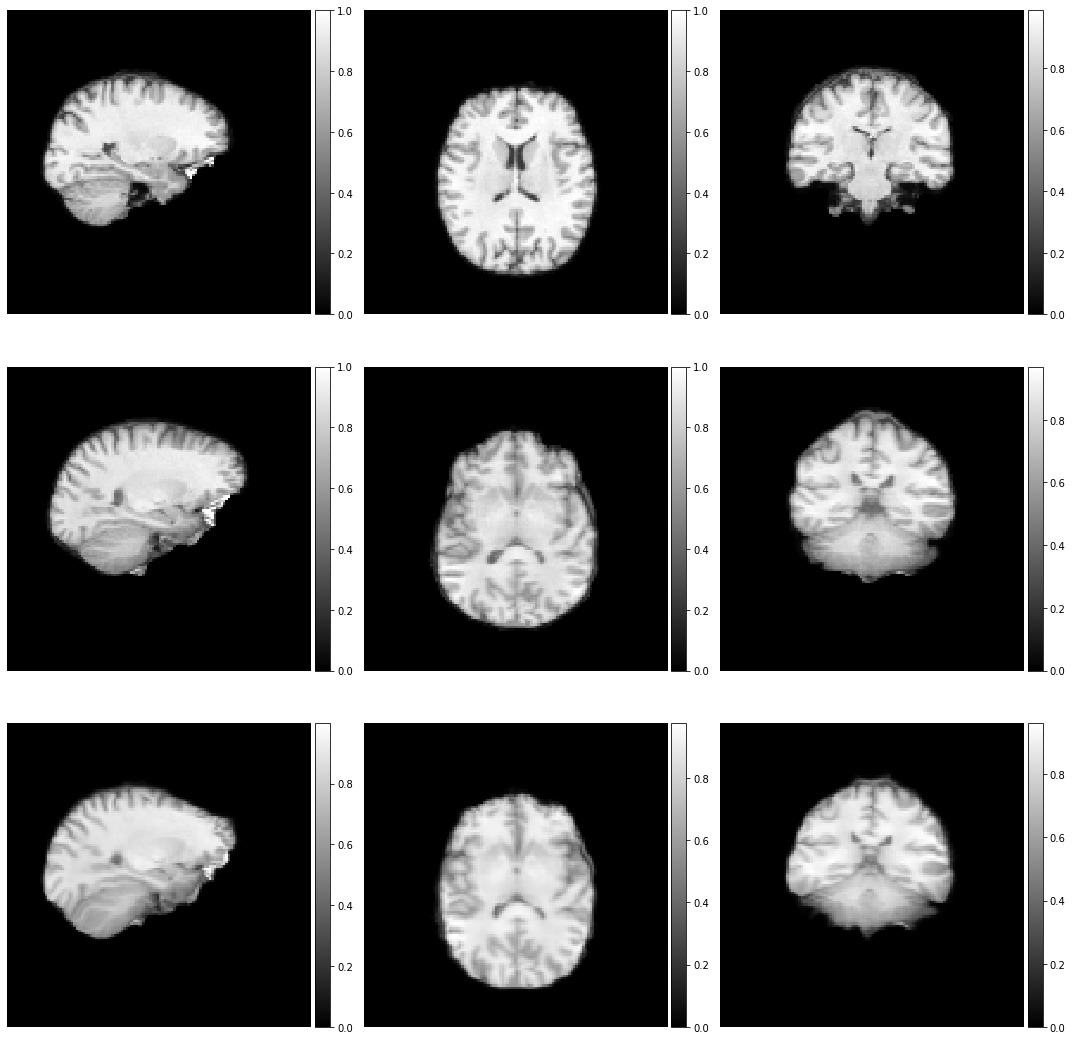

In [147]:
mid_slices_fixed = [np.take(mynb_np1, 52, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 52, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 52, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

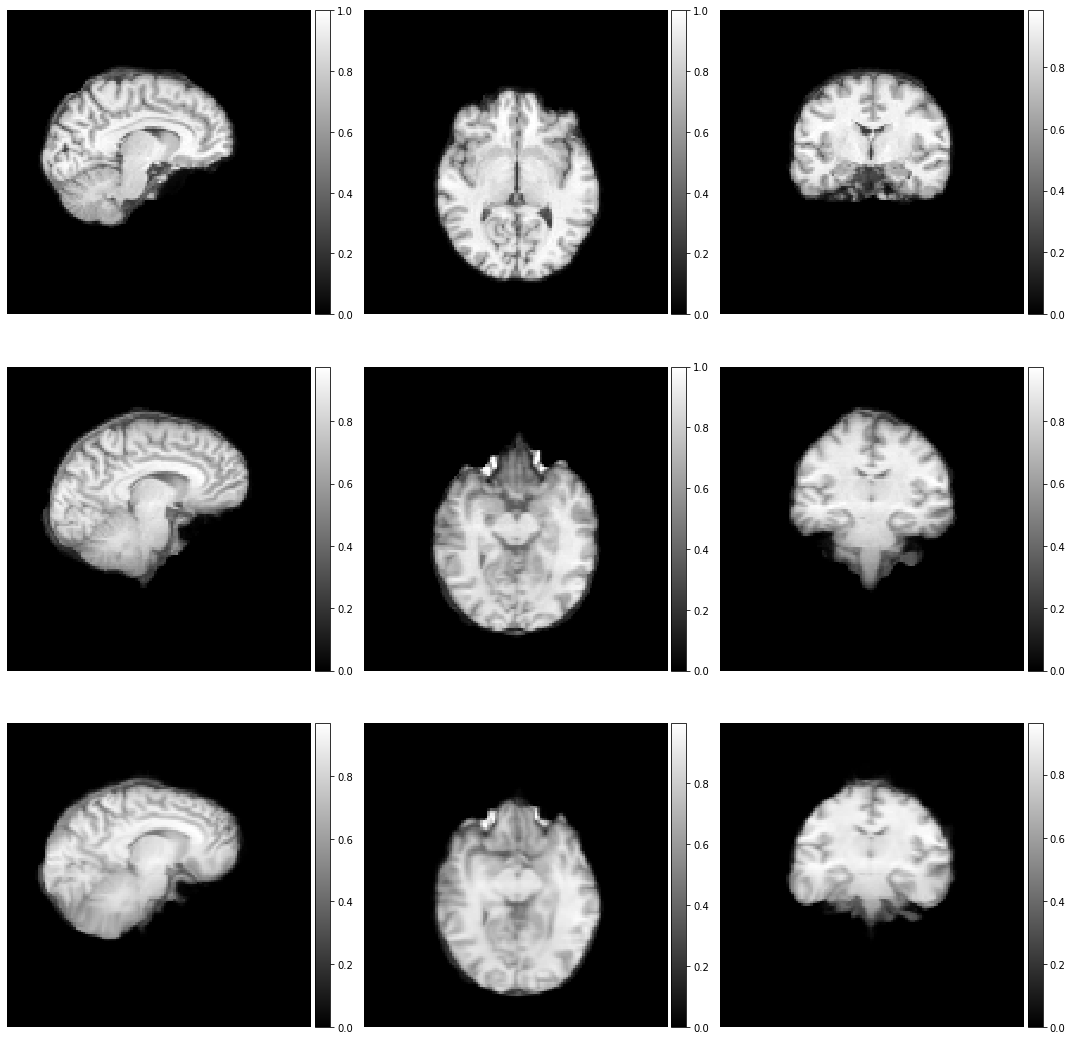

In [108]:
mid_slices_fixed = [np.take(mynb_np1, 60, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 60, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 60, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

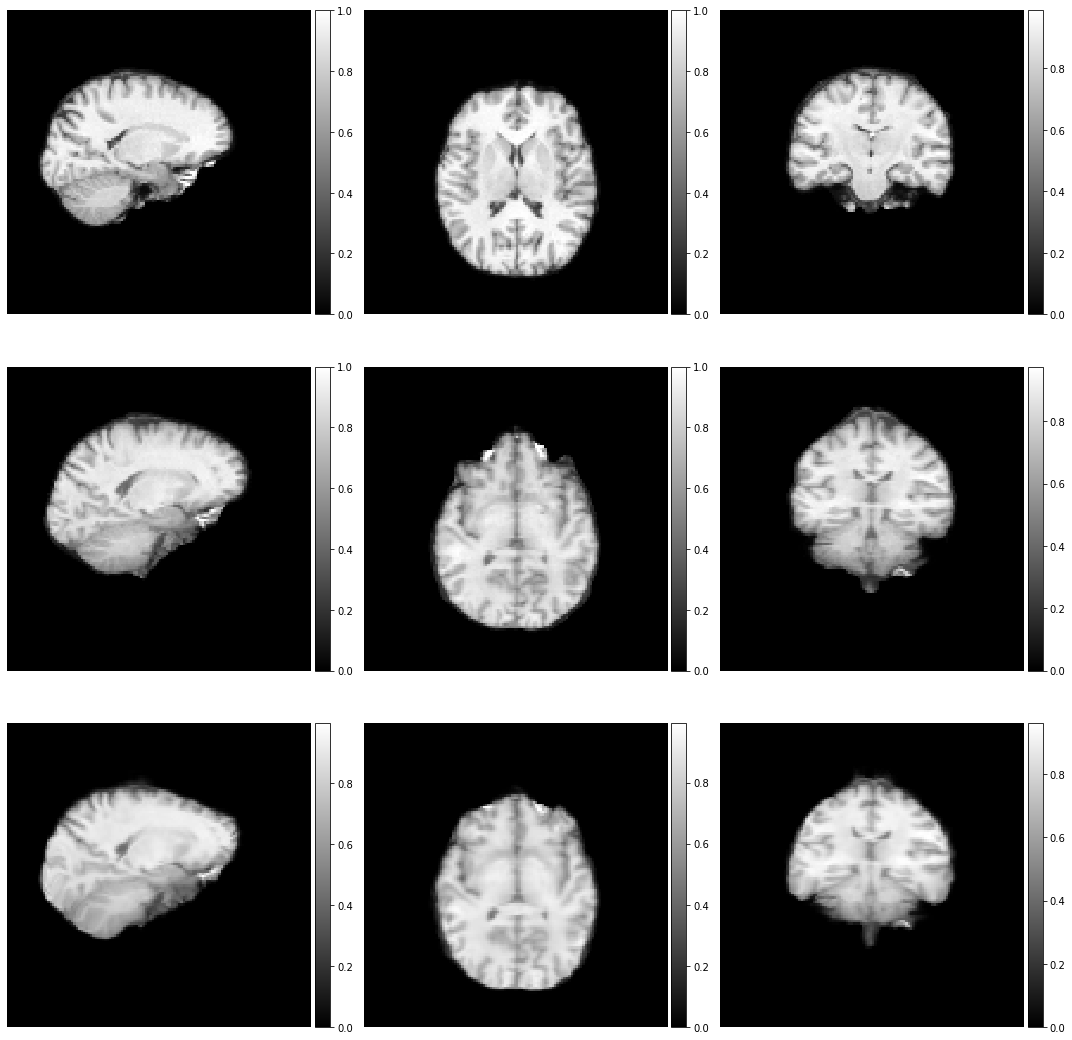

In [95]:
mid_slices_fixed = [np.take(mynb_np1, 55, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 55, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 55, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

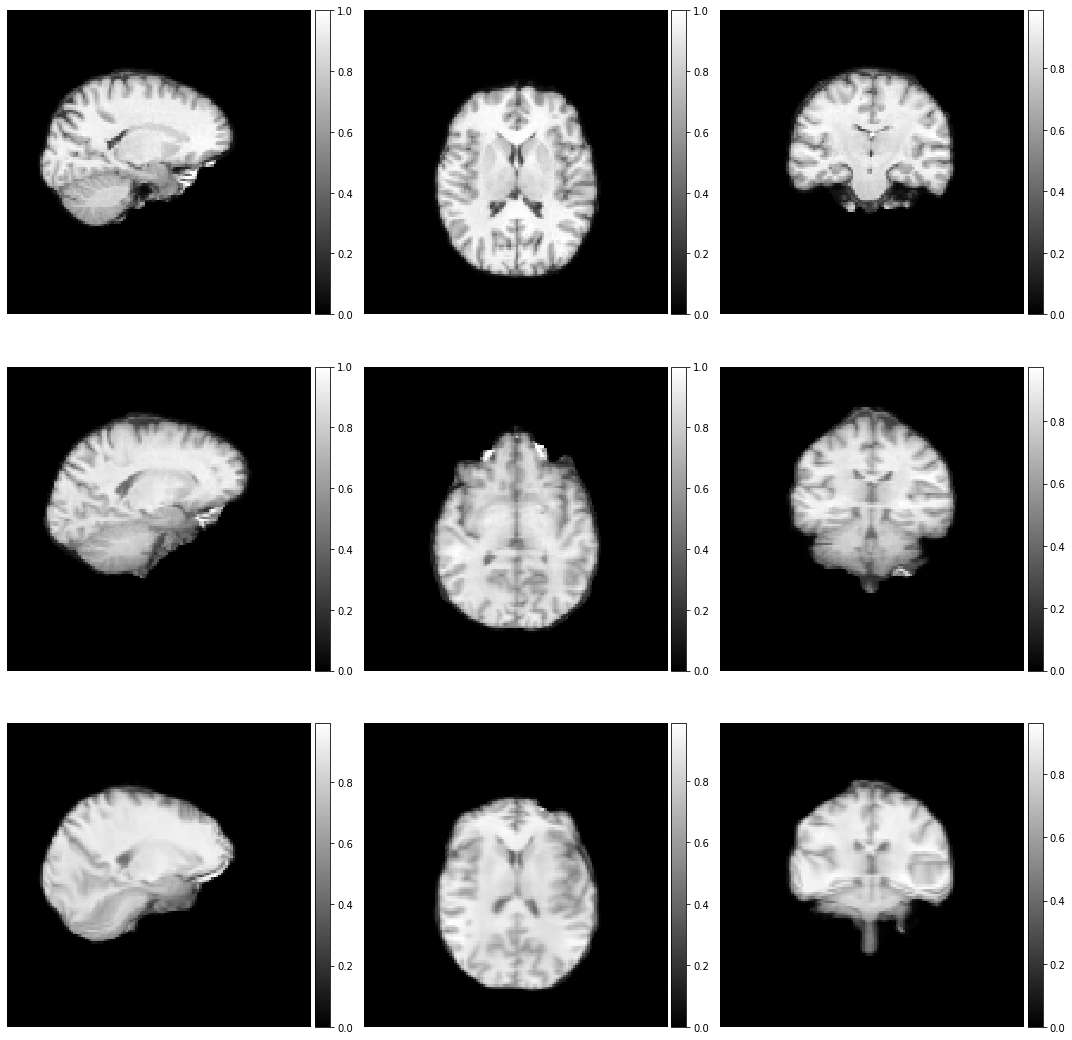

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 55, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 55, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 55, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

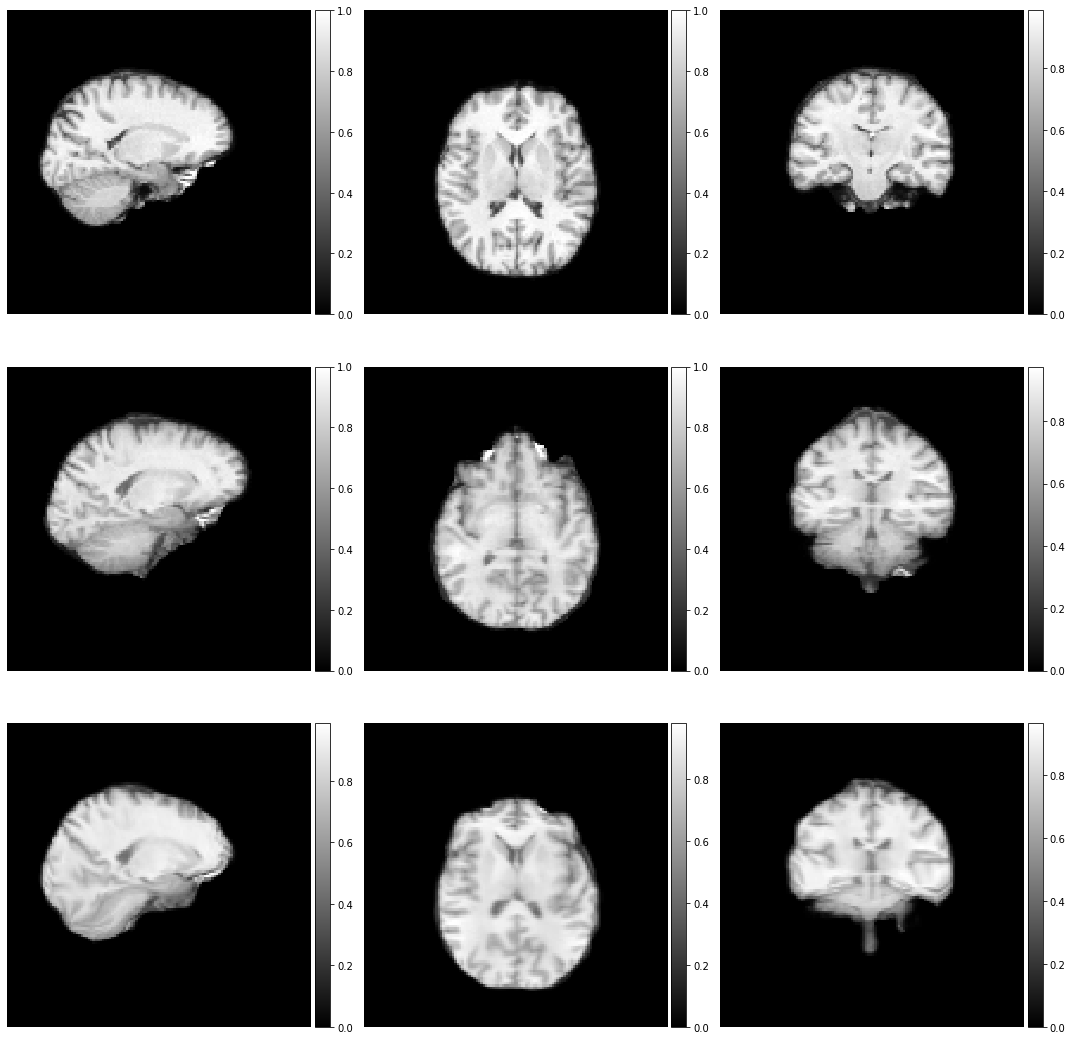

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 55, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 55, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 55, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

At 26 epochs - 4096 nodes - 16, 16, 16 feature map

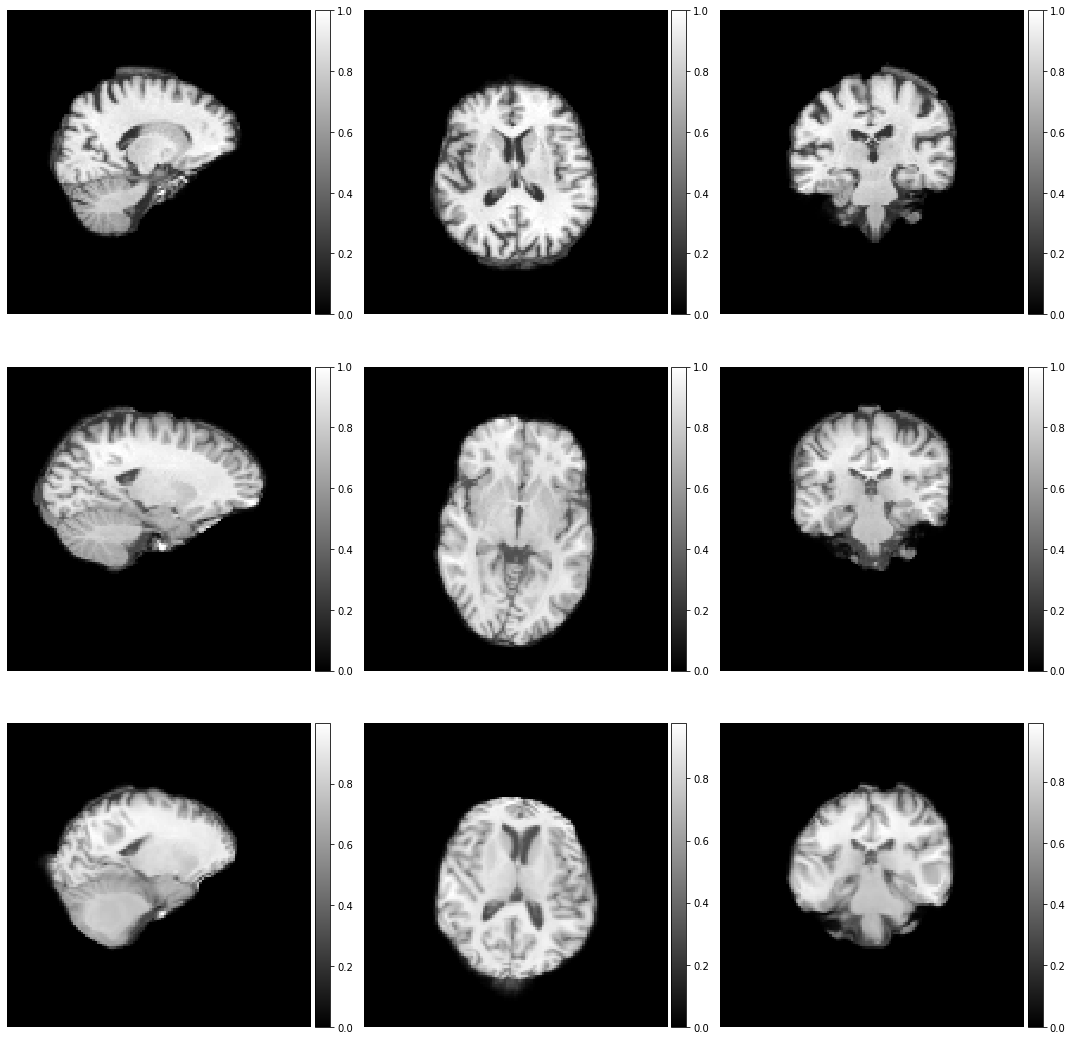

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 55, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 55, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 55, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

At 20 epochs - 4096 nodes - 16, 16, 16 feature map

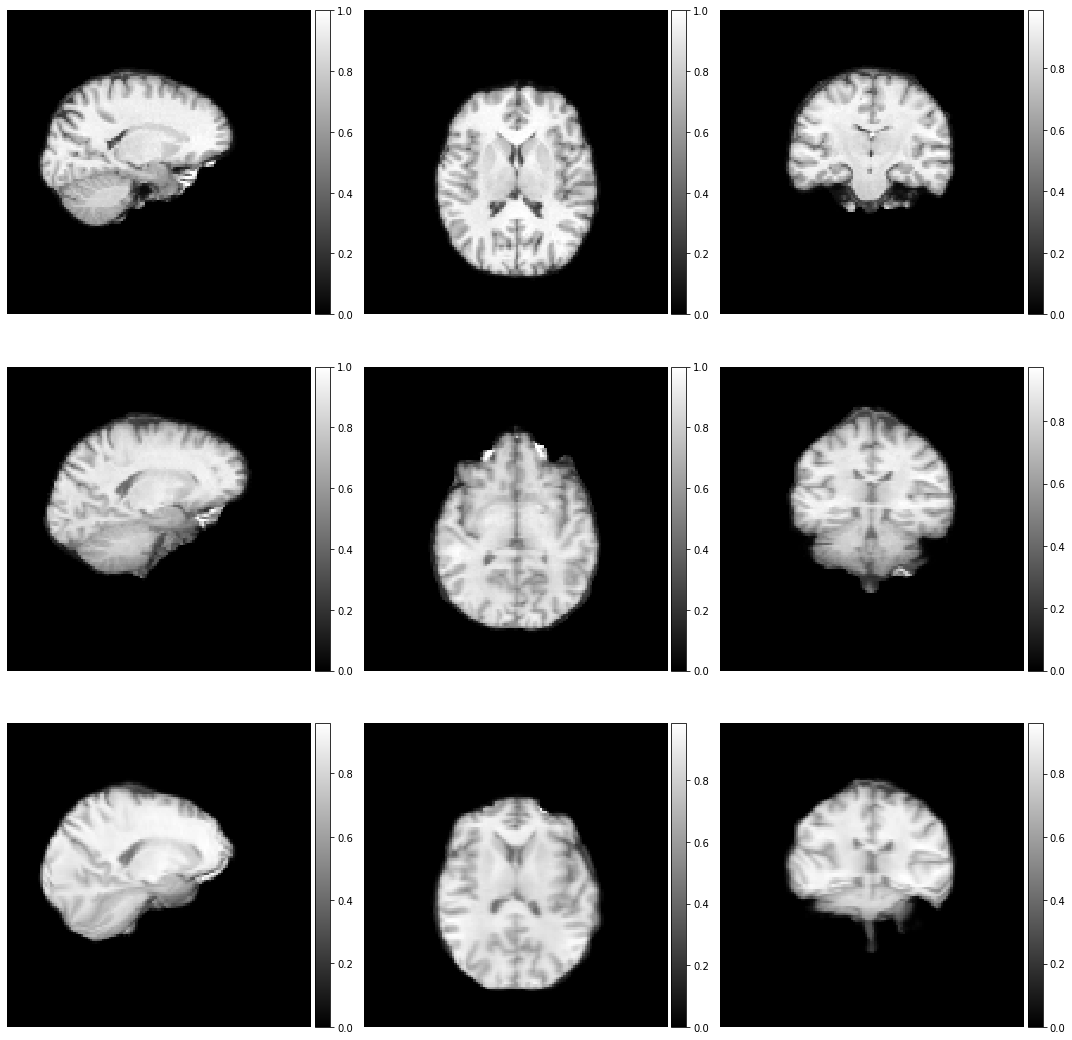

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 55, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 55, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 55, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

At 10 epochs - 4096 nodes - 16, 16, 16 feature map

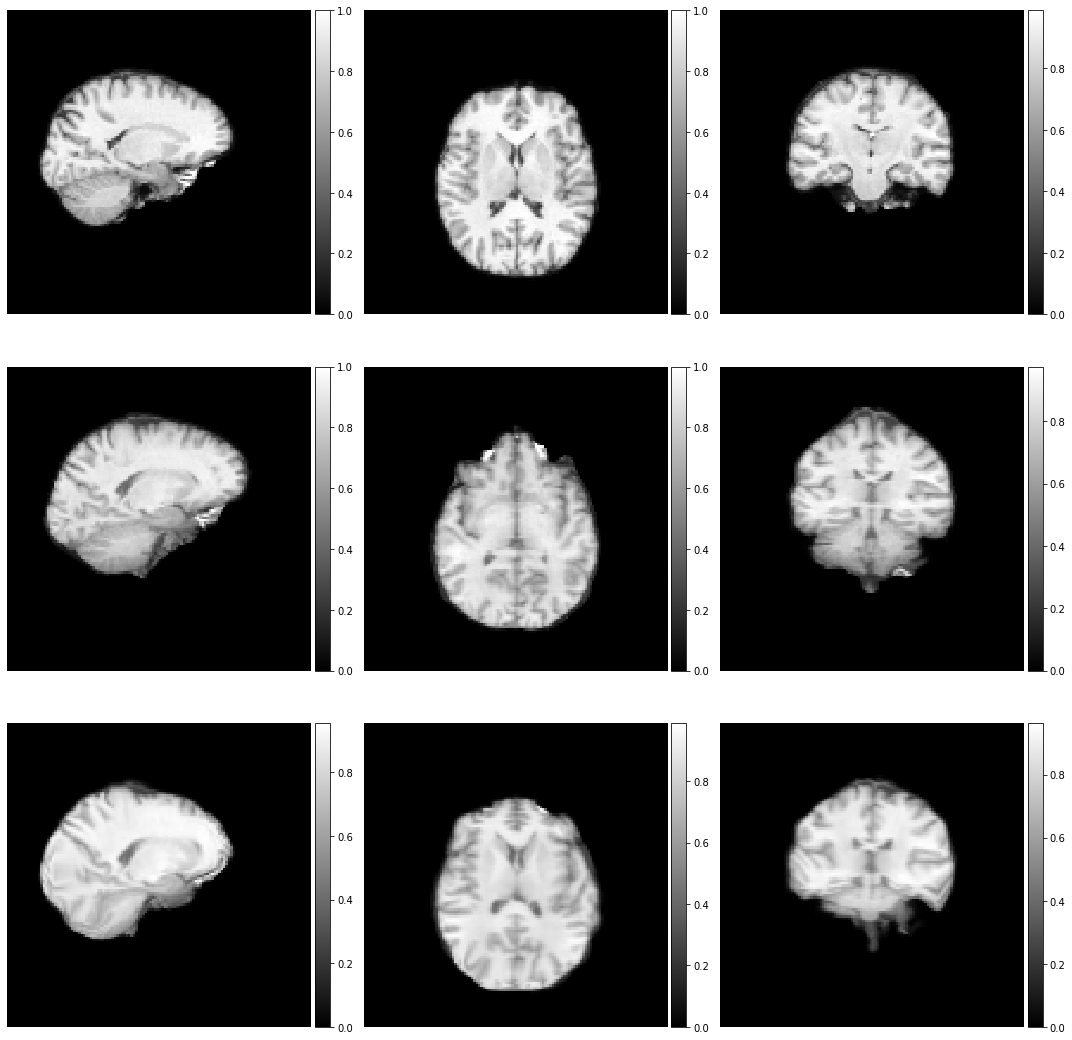

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 55, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 55, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 55, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

At 40 epochs - 512 nodes - 8,8,8 feature map


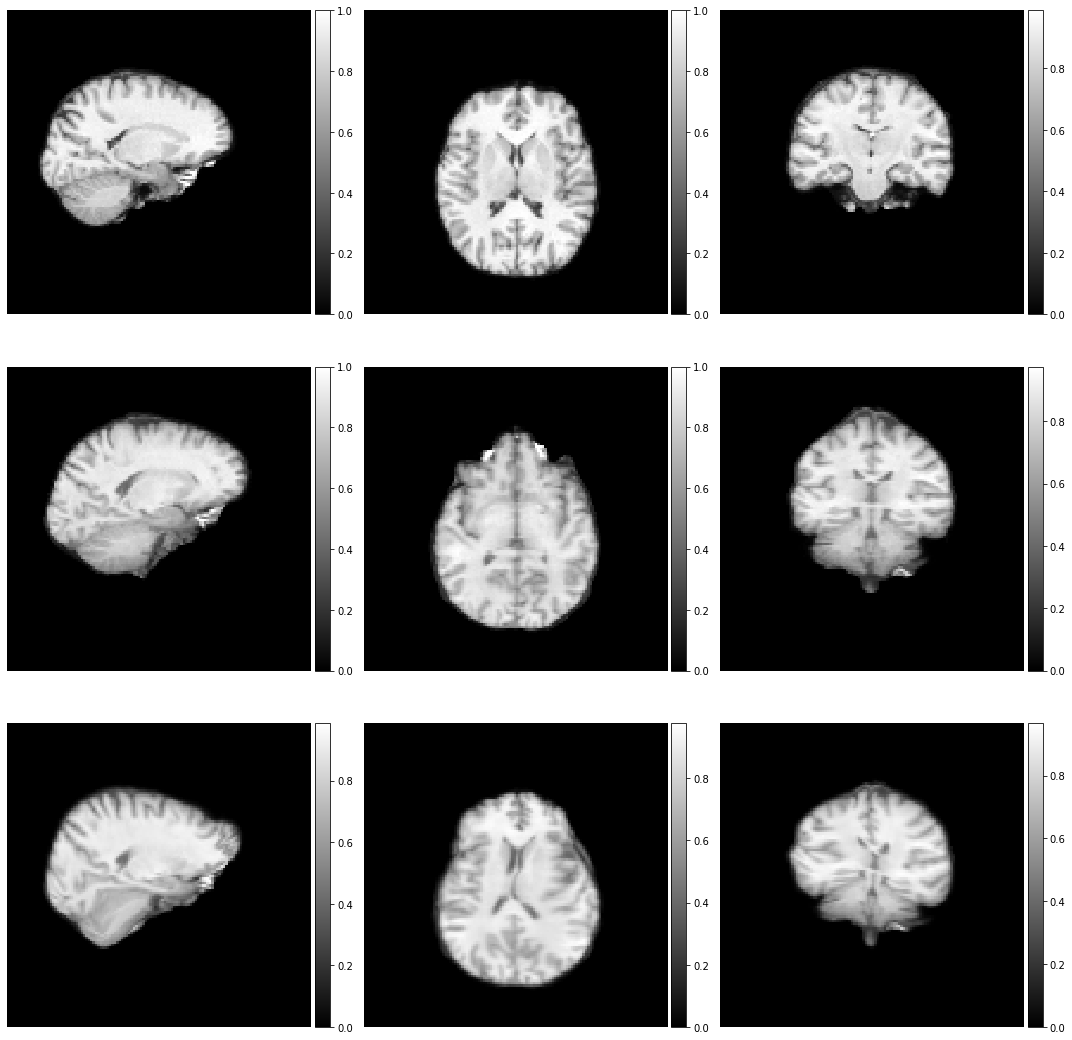

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 55, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 55, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 55, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

At 70 epochs - 512 nodes - 8,8,8 feature map

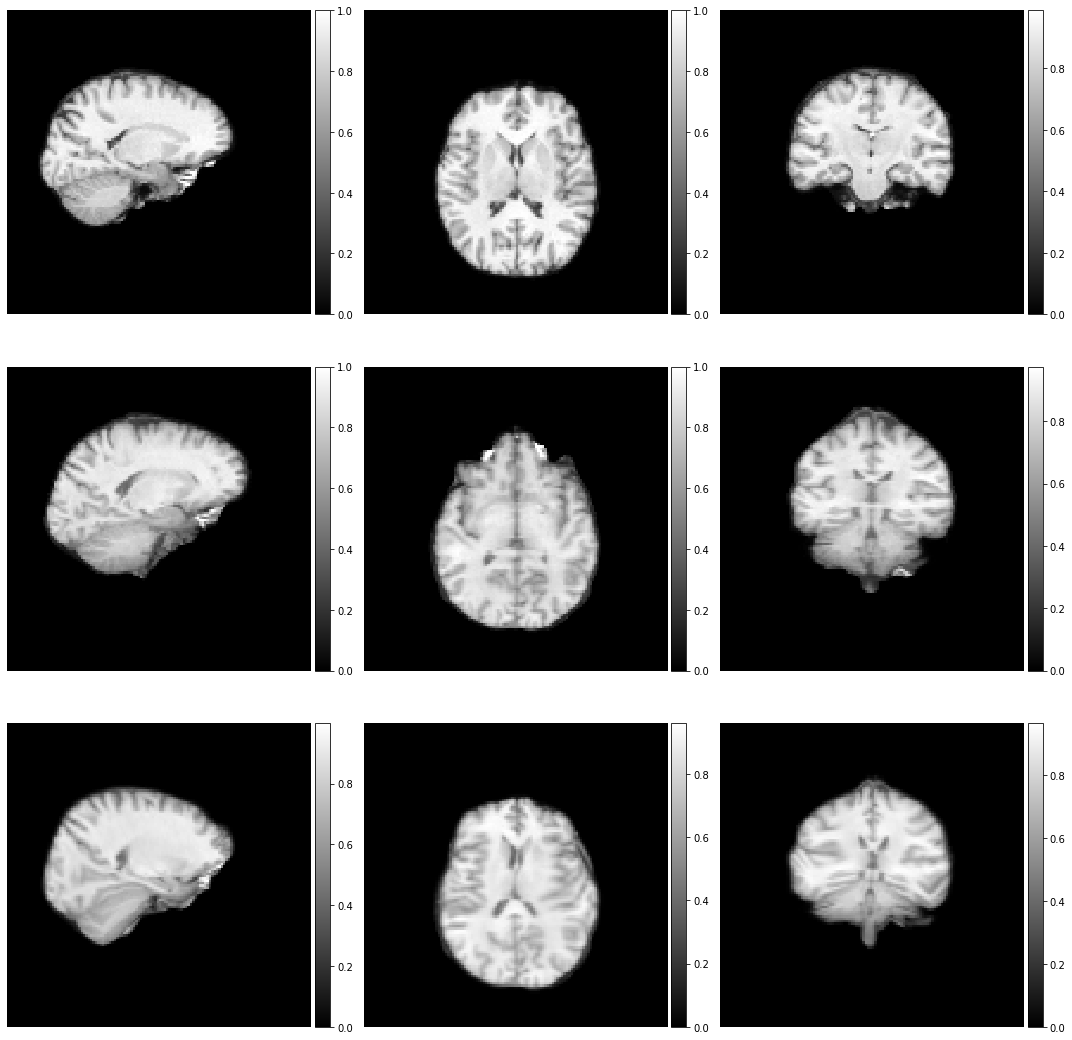

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 55, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 55, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 55, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);

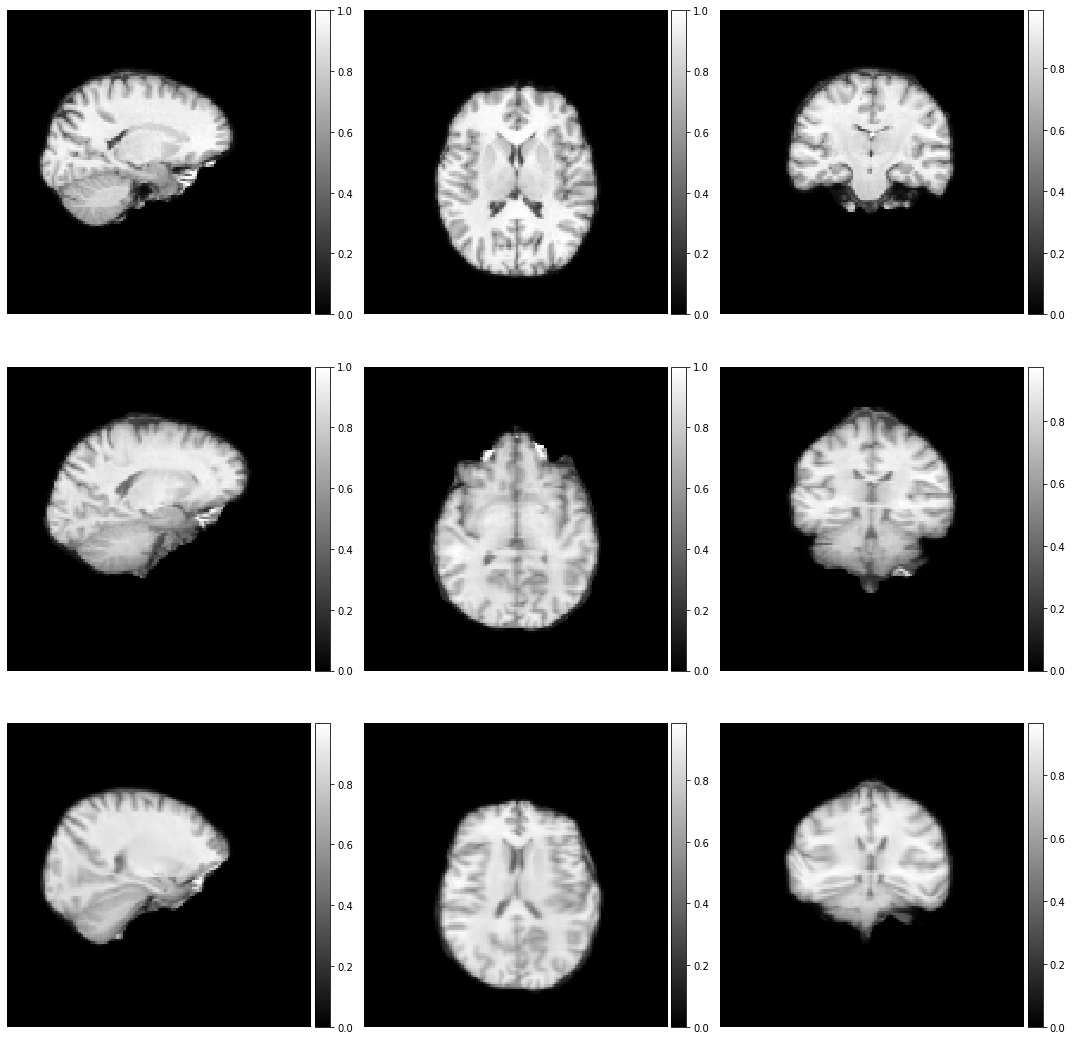

In [ ]:
mid_slices_fixed = [np.take(mynb_np1, 55, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_moving = [np.take(mynb_np2, 55, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_pred = [np.take(warped_img_np, 55, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_moving + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[3,3]);